# SVC Model Performance

In this notebook, I'm going to use the data set that gave us the best results when running logistic regression (unigram TFIDF with 10k features) and run it through SVC model

SVC is non-linear. And from looking at our data in our previous notebook, it looks to be non-linear so hopefully results will be better

# Results

Unfortunately, not only did SVC take significantly longer to train and predict. It was did not do well at all in our classification. All predictions came back with result of Star rating 4

In [25]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import util.model_util as mu
import util.report_util as ru
import logging
import json

%matplotlib inline
sns.set()
logging.basicConfig(level=logging.INFO)

log = logging.getLogger(__name__)

pd.set_option('max_colwidth', 150)

CONFIG_DIR = "../config"
CONFIG_FILE_SVC = f'{CONFIG_DIR}/2019-11-01-run_classifiers-svc.csv'
REPORT_DIR = "../reports"
REPORT_FILE_SVC = f'{REPORT_DIR}/2019-11-01-run_classifiers-svc-report.csv'
REPORT_FILE_LR = f'{REPORT_DIR}/2019-11-01-run_classifiers-50k-report.csv'

# configuration file 


In [23]:
config_svc = pd.read_csv(CONFIG_FILE_SVC)
config_svc

,data_dir,data_file,class_column,dtype,drop_columns,model_name,sampling,status,status_date,message
0,../dataset/feature_files,review_body-tfidf-df_default-ngram11-49784-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",SVC_RBF,NaN,success,2019-11-04 00:29:17,NaN


Our SVC Classifier was created in the following manner:

```python
 classifier = SVC(class_weight='balanced', verbose=1, random_state=1, decision_function_shape='ovo')
```


## Loading our report


In [28]:
report_svc = ru.load_report(REPORT_FILE_SVC)
report_lr = ru.load_report(REPORT_FILE_LR)

In [44]:
# combine LR results with SVC so we can graph later
report_lr[(report_lr.model_name == 'LRB') & (report_lr.feature_engineering == 'tfidf') & (report_lr.config_ngram == 'ngram11')]
report = report_svc.append(report_lr[(report_lr.model_name == 'LRB') & 
                                     (report_lr.feature_engineering == 'tfidf') & 
                                     (report_lr.config_ngram == 'ngram11')])
report

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,config_ngram,sample_size,feature_size,has_lda,lda_str,has_sampling,sampling_str,label_column,feature_summary,feature_summary_sampling
0,0.000000,0.000000,0.00000,1735.0,0.000000,0.000000,0.000000,806.0,0.000000,0.000000,...,ngram11,49784,10000,False,nolda,False,sampling_none,star_rating,tfidf-ngram11-10000,tfidf-ngram11-sampling_none
5,0.641905,0.631696,0.65245,1735.0,0.266348,0.216447,0.346154,806.0,0.288041,0.253585,...,ngram11,49784,10000,False,nolda,True,nosmote,star_rating,tfidf-ngram11-10000,tfidf-ngram11-nosmote


# Training Time

SVC took significantly longer to train and to predict

14 hours to train
2.5 hours to predict

In [39]:
report[["train_time_min", "predict_time_min"]

,train_time_min,predict_time_min,total_time_min
0,843.89,153.64,7.1
5,8.34,0.01,6.2


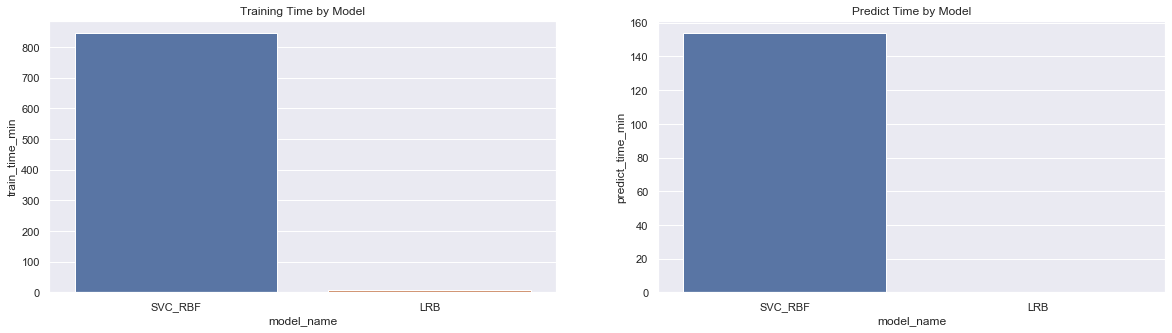

In [43]:
f, a = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(data=report, x="model_name", y="train_time_min", ax=a[0])
_ = a[0].set_title("Training Time by Model")
sns.barplot(data=report, x="model_name", y="predict_time_min", ax=a[1])
_ = a[1].set_title("Predict Time by Model")


# Model Result

Looks like SVC was not able to classify at all

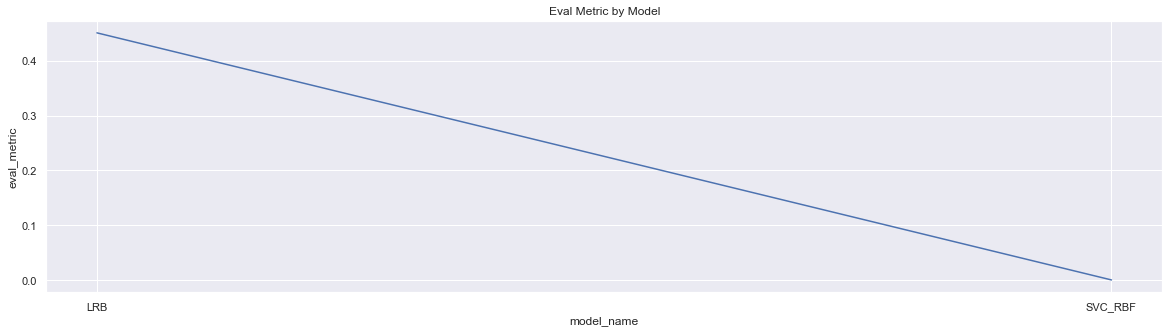

In [19]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

sns.lineplot(data=report, x="model_name", y="eval_metric")
_ = plt.title("Eval Metric by Model")

# Confusion Matrix for SVC

Looking everything got classified as star-4

In [32]:
pd.DataFrame(json.loads(report_svc.confusion_matrix.values[0])).rename(
                {"0":"1", "1":"2", "2":"3", "3":"4", "4":"5"}, axis=1
)

,0,1,2,3,4
0,0,0,0,1735,0
1,0,0,0,806,0
2,0,0,0,1167,0
3,0,0,0,2103,0
4,0,0,0,6635,0
